# Estimate amount of SPM that needs to be added

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar
import seaborn as sns

%matplotlib inline

###### Parameters:

In [2]:
# domain dimensions:
imin, imax = 1479, 2179
jmin, jmax = 159, 799

# results to plot:
year    = 2015
month   = 8
folder_ref = f'/data/brogalla/run_storage/Mn-reference-202110/ANHA12_ref-{year}_20211012/'
folder_spm = f'/data/brogalla/run_storage/Mn-spm-202110/ANHA12_spm-{year}_20211026/'

# colours:
rivers = '#bada55'
dirty  = '#64707b'
clean  = '#cee7fd'

##### Load files:

Model results

In [3]:
file = f'ANHA12_EXH006_{year}_monthly.nc'

Mn_model_ref = nc.Dataset(folder_ref+file)
Mn_model_spm = nc.Dataset(folder_spm+file)

lon_model    = np.array(Mn_model_ref.variables['nav_lon'])
lat_model    = np.array(Mn_model_ref.variables['nav_lat'])
depths_model = np.array(Mn_model_ref.variables['deptht'])
mn_dis_ref   = np.array(Mn_model_ref.variables['dissolmn'])
mn_dis_spm   = np.array(Mn_model_spm.variables['dissolmn'])

Meshes

In [4]:
mesh       = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_lon   = np.array(mesh.variables['nav_lon'])
mesh_lat   = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'][0])
tmask      = np.array(mesh.variables['tmask'][0,:,:,:])
Z_masked   = np.ma.masked_where((tmask > 0.1), tmask) 

Observations

In [5]:
Mn_data  = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Mn_Integrated_Data_UBC-UVic_4-17-19.csv')

dMn_CB1 = Mn_data['CB1'].dropna()[1:].astype('float');
dMn_CB2  = Mn_data['CB2'].dropna()[1:].astype('float'); dMn_CB3 = Mn_data['CB3'].dropna()[1:].astype('float');
dMn_CB4  = Mn_data['CB4'].dropna()[1:].astype('float'); dMn_CAA1 = Mn_data['CAA1'].dropna()[1:].astype('float');
dMn_CAA2 = Mn_data['CAA2'].dropna()[1:].astype('float'); dMn_CAA3 = Mn_data['CAA3'].dropna()[1:].astype('float');
dMn_CAA4 = Mn_data['CAA4'].dropna()[1:].astype('float'); dMn_CAA5 = Mn_data['CAA5'].dropna()[1:].astype('float');
dMn_CAA6 = Mn_data['CAA6'].dropna()[1:].astype('float'); dMn_CAA7 = Mn_data['CAA7'].dropna()[1:].astype('float');
dMn_CAA8 = Mn_data['CAA8'].dropna()[1:].astype('float'); dMn_CAA9 = Mn_data['CAA9'].dropna()[1:].astype('float');

std_CB1 = Mn_data['Unnamed: 44'][1:].astype('float').fillna(0)[0:11];
std_CB2  = Mn_data['Unnamed: 47'].dropna()[1:].astype('float'); std_CB3 = Mn_data['Unnamed: 50'][1:].astype('float').fillna(0)[0:22];
std_CB4  = Mn_data['Unnamed: 53'].dropna()[1:].astype('float'); std_CAA1 = Mn_data['Unnamed: 17'].dropna()[1:].astype('float');
std_CAA2 = Mn_data['Unnamed: 20'].dropna()[1:].astype('float'); std_CAA3 = Mn_data['Unnamed: 23'].dropna()[1:].astype('float');
std_CAA4 = Mn_data['Unnamed: 26'].dropna()[1:].astype('float'); std_CAA5 = Mn_data['Unnamed: 29'].dropna()[1:].astype('float');
std_CAA6 = Mn_data['Unnamed: 32'].dropna()[1:].astype('float'); std_CAA7 = Mn_data['Unnamed: 35'].dropna()[1:].astype('float');
std_CAA8 = Mn_data['Unnamed: 38'].dropna()[1:].astype('float'); std_CAA9 = Mn_data['Unnamed: 41'].dropna()[1:].astype('float');

depth_CB1 = Mn_data['Depth.14'].dropna();
depth_CB2  = Mn_data['Depth.15'].dropna(); depth_CB3 = Mn_data['Depth.16'].dropna();
depth_CB4  = Mn_data['Depth.17'].dropna(); depth_CAA1 = Mn_data['Depth.5'].dropna();
depth_CAA2 = Mn_data['Depth.6'].dropna(); depth_CAA3 = Mn_data['Depth.7'].dropna();
depth_CAA4 = Mn_data['Depth.8'].dropna(); depth_CAA5 = Mn_data['Depth.9'].dropna();
depth_CAA6 = Mn_data['Depth.10'].dropna(); depth_CAA7 = Mn_data['Depth.11'].dropna();
depth_CAA8 = Mn_data['Depth.12'].dropna(); depth_CAA9 = Mn_data['Depth.13'].dropna();

In [6]:
Pb_data   = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')
stn_names = Pb_data['Station names'].dropna().astype('str')
lons      = Pb_data['station lon'].astype('float').dropna().values
lats      = Pb_data['Station lat'].astype('float').dropna().values

##### Define functions

In [7]:
def find_index_ANHA12_full(transect_lons, transect_lats, ANHA12_lon=mesh_lon, ANHA12_lat=mesh_lat):
    # input:   ANHA12_lon, ANHA12_lat       --- 2400x1632 coordinates
    #          transect_lons, transect_lats --- list of lat and lon values to include in the transect
    # output:  i, j                         --- lists of coordinates associated with these points
    
    transect_i = np.array([])
    transect_j = np.array([])
    if isinstance(transect_lons,float):
        i, j = ar.find_closest_model_point(transect_lons, transect_lats, ANHA12_lon, ANHA12_lat)
        transect_i = i
        transect_j = j
    else:
        for k in range(0,len(transect_lons)):
            i, j = ar.find_closest_model_point(transect_lons[k], transect_lats[k], ANHA12_lon, ANHA12_lat)
            transect_i = np.append(transect_i, i)
            transect_j = np.append(transect_j, j)
    
    return transect_i, transect_j

In [8]:
def find_index_ANHA12_sub(transect_lons, transect_lats, ANHA12sub_lon=lon_model, ANHA12sub_lat=lat_model):
    # input:   ANHA12sub_lon, ANHA12sub_lat --- 570x600 coordinates
    #          transect_lons, transect_lats --- list of lat and lon values to include in the transect
    # output:  i, j                         --- lists of coordinates associated with these points
    
    transect_i = np.array([])
    transect_j = np.array([])
    
    if isinstance(transect_lons,float):
        i, j = ar.find_closest_model_point(transect_lons, transect_lats, ANHA12sub_lon, ANHA12sub_lat)
        transect_i = i
        transect_j = j
    else:
        for k in range(0,len(transect_lons)):
            i, j = ar.find_closest_model_point(transect_lons[k], transect_lats[k], ANHA12sub_lon, ANHA12sub_lat)
            transect_i = np.append(transect_i, i)
            transect_j = np.append(transect_j, j)
    
    return transect_i, transect_j

In [9]:
def calc_scatter(name, dmn_stn, depth_stn):
    lon_station = lons[stn_names==name]
    lat_station = lats[stn_names==name]
    model_stni, model_stnj = find_index_ANHA12_sub(lon_station, lat_station)
    model_i, model_j = find_index_ANHA12_full(lon_station, lat_station)
    model_i    = int(model_i);    model_j    = int(model_j);
    model_stni = int(model_stni); model_stnj = int(model_stnj);
    
    mn_ij1 = mn_dis_ref[8, 0, :, model_stni, model_stnj]*10**9
    mn_ij2 = mn_dis_spm[8, 0, :, model_stni, model_stnj]*10**9
    mn_ij1_masked = np.ma.masked_where((tmask[:, model_i, model_j] < 0.1), mn_ij1)
    mn_ij2_masked = np.ma.masked_where((tmask[:, model_i, model_j] < 0.1), mn_ij2)
    
    m1 = []; m2 = [];
    for depth_obs in depth_stn[(depth_stn < 50) & (depth_stn > 5)]:
        d1 = np.argmin(np.abs(depths_model-depth_obs))
        m1.append(mn_ij1_masked[d1])
        m2.append(mn_ij2_masked[d1])
    
    dmn_m1  = m1; dmn_m2  = m2;
    dmn_obs = list(dmn_stn[(depth_stn < 50) & (depth_stn > 5)])
    
    return dmn_m1, dmn_m2, dmn_obs

#### Figure:

In [10]:
dmn_m1CAA1, dmn_m2CAA1, dmn_obCAA1 = calc_scatter('CAA1', dMn_CAA1, depth_CAA1)
dmn_m1CAA2, dmn_m2CAA2, dmn_obCAA2 = calc_scatter('CAA2', dMn_CAA2, depth_CAA2)
dmn_m1CAA3, dmn_m2CAA3, dmn_obCAA3 = calc_scatter('CAA3', dMn_CAA3, depth_CAA3)
dmn_m1CAA4, dmn_m2CAA4, dmn_obCAA4 = calc_scatter('CAA4', dMn_CAA4, depth_CAA4)
dmn_m1CAA5, dmn_m2CAA5, dmn_obCAA5 = calc_scatter('CAA5', dMn_CAA5, depth_CAA5)
dmn_m1CAA6, dmn_m2CAA6, dmn_obCAA6 = calc_scatter('CAA6', dMn_CAA6, depth_CAA6)
dmn_m1CAA7, dmn_m2CAA7, dmn_obCAA7 = calc_scatter('CAA7', dMn_CAA7, depth_CAA7)
dmn_m1CAA8, dmn_m2CAA8, dmn_obCAA8 = calc_scatter('CAA8', dMn_CAA8, depth_CAA8)
dmn_m1CAA9, dmn_m2CAA9, dmn_obCAA9 = calc_scatter('CAA9', dMn_CAA9, depth_CAA9)

dmn_m1CB1, dmn_m2CB1, dmn_obCB1 = calc_scatter('CB1', dMn_CB1, depth_CB1)
dmn_m1CB2, dmn_m2CB2, dmn_obCB2 = calc_scatter('CB2', dMn_CB2, depth_CB2)
dmn_m1CB3, dmn_m2CB3, dmn_obCB3 = calc_scatter('CB3', dMn_CB3, depth_CB3)
dmn_m1CB4, dmn_m2CB4, dmn_obCB4 = calc_scatter('CB4', dMn_CB4, depth_CB4)

In [11]:
dmn_dirty = dmn_m1CAA1 + dmn_m1CAA2 + dmn_m1CAA3 + dmn_m1CAA4 + dmn_m1CAA5 + \
            dmn_m1CAA6 + dmn_m1CAA7 + dmn_m1CAA8 + dmn_m1CAA9 + dmn_m1CB1 + \
            dmn_m1CB2  + dmn_m1CB3  + dmn_m1CB4
dmn_dirty_CB = dmn_m1CB1 + dmn_m1CB2  + dmn_m1CB3  + dmn_m1CB4

dmn_spm = dmn_m2CAA1 + dmn_m2CAA2 + dmn_m2CAA3 + dmn_m2CAA4 + dmn_m2CAA5 + \
            dmn_m2CAA6 + dmn_m2CAA7 + dmn_m2CAA8 + dmn_m2CAA9 + dmn_m2CB1 + \
            dmn_m2CB2  + dmn_m2CB3  + dmn_m2CB4
dmn_spm_CB = dmn_m2CB1 + dmn_m2CB2  + dmn_m2CB3  + dmn_m2CB4

dmn_observ = dmn_obCAA1 + dmn_obCAA2 + dmn_obCAA3 + dmn_obCAA4 + dmn_obCAA5 + \
             dmn_obCAA6 + dmn_obCAA7 + dmn_obCAA8 + dmn_obCAA9 + dmn_obCB1 + \
             dmn_obCB2  + dmn_obCB3  + dmn_obCB4
dmn_observ_CB = dmn_obCB1 + dmn_obCB2  + dmn_obCB3  + dmn_obCB4

delta_dmn_spm = np.array(dmn_spm) - np.array(dmn_dirty)

In [12]:
dmn_dirty_continental = dmn_m1CB1  + dmn_m1CAA8 + dmn_m1CAA6 + dmn_m1CAA7 + dmn_m1CAA5 + dmn_m1CAA4
dmn_dirty_glacial     = dmn_m1CAA1 + dmn_m1CAA9 + dmn_m1CAA2 + dmn_m1CAA3
dmn_spm_continental   = dmn_m2CB1  + dmn_m2CAA8 + dmn_m2CAA6 + dmn_m2CAA7 + dmn_m2CAA5 + dmn_m2CAA4
dmn_spm_glacial       = dmn_m2CAA1 + dmn_m2CAA9 + dmn_m2CAA2 + dmn_m2CAA3
dmn_obs_continental   = dmn_obCB1  + dmn_obCAA8 + dmn_obCAA6 + dmn_obCAA7 + dmn_obCAA5 + dmn_obCAA4
dmn_obs_glacial       = dmn_obCAA1 + dmn_obCAA9 + dmn_obCAA2 + dmn_obCAA3

Estimate SPM contribution objectively:

In [13]:
def susans_willmott_score(Obs, Pred, print_on=False):
    N = np.count_nonzero(~np.isnan(Obs))
    
    numerator   = np.sum([(Pred[i]-Obs[i])**2 for i in range(0,N)])
    term1       = np.abs(Pred - np.nanmean(Pred))
    term2       = np.abs(Obs - np.nanmean(Obs))
    denominator = np.sum([(term1[i]+term2[i])**2 for i in range(0,N)])
    deviation   = numerator / denominator
    
    willmott    = 1 - (1 - deviation)
    if print_on:
        print(f'Willmott skill score: {willmott:.2f}')
        
    return willmott

In [14]:
def bias(Obs, Pred, print_on=False):
    N = np.count_nonzero(~np.isnan(Obs))
    
#     bias_total = np.average([np.abs(Pred[i] - Obs[i]) for i in range(0, N)])
    bias_total = np.average(Pred) - np.average(Obs)
    
    if print_on:
        print(f'Bias: {bias_total:.2f}')
    
    return bias_total

In [15]:
w_dirty_continental = susans_willmott_score(dmn_obs_continental, dmn_dirty_continental, print_on=True)
w_spm_continental   = susans_willmott_score(dmn_obs_continental, dmn_spm_continental, print_on=True)
w_dirty_glacial     = susans_willmott_score(dmn_obs_glacial, dmn_dirty_glacial, print_on=True)
w_spm_glacial       = susans_willmott_score(dmn_obs_glacial, dmn_spm_glacial, print_on=True)

w_spm_all       = susans_willmott_score(dmn_observ, dmn_dirty, print_on=True)

Willmott skill score: 0.81
Willmott skill score: 0.76
Willmott skill score: 0.63
Willmott skill score: 0.86
Willmott skill score: 0.73


In [16]:
b_dirty_continental = bias(dmn_obs_continental, dmn_dirty_continental, print_on=True)
b_spm_continental   = bias(dmn_obs_continental, dmn_spm_continental, print_on=True)
b_dirty_glacial     = bias(dmn_obs_glacial, dmn_dirty_glacial, print_on=True)
b_spm_glacial       = bias(dmn_obs_glacial, dmn_spm_glacial, print_on=True)

b_spm_all           = bias(dmn_observ, dmn_dirty, print_on=True)

Bias: -2.59
Bias: -2.49
Bias: -0.96
Bias: 0.83
Bias: -1.88


In [17]:
def predict_spm(dmn_obs, dmn_dirty, delta_dmn, a_values):
    
    willmotts = []
    biases    = []

    for a in a_values:
        dmn_test = dmn_dirty + a*delta_dmn
        w = susans_willmott_score(dmn_obs, dmn_test)
        b = bias(dmn_obs, dmn_test)

        willmotts.append(w)
        biases.append(b)
    
    return np.array(willmotts), np.array(biases)

In [18]:
delta_dmn_glacial     = np.array(dmn_spm_glacial)     - np.array(dmn_dirty_glacial)
delta_dmn_continental = np.array(dmn_spm_continental) - np.array(dmn_dirty_continental)

# multipliers to range over
a_values  = np.linspace(-5,10,1000)

willmotts_glacial    , bias_glacial     = predict_spm(dmn_obs_glacial, dmn_dirty_glacial, delta_dmn_glacial, a_values)
willmotts_continental, bias_continental = predict_spm(dmn_obs_continental, dmn_dirty_continental, delta_dmn_continental, a_values)
    
ind_opt_glacial     = np.argmin(willmotts_glacial)
ind_opt_continental = np.argmin(willmotts_continental)
print(f'------- SWillmott based metrics: ----------')
print(f'Best fit SPM content multiplier: glacial ({a_values[ind_opt_glacial]:.2f}), continental ({a_values[ind_opt_continental]:.2f})')
print(f'Associated Willmott score: glacial (optimal: {willmotts_glacial[ind_opt_glacial]:.2f}, was: {w_dirty_glacial:.2f}), ' + \
      f'continental (optimal: {willmotts_continental[ind_opt_continental]:.2f}, was: {w_dirty_continental:.2f})')

bind_opt_glacial     = np.argmin(np.abs(bias_glacial))
bind_opt_continental = np.argmin(np.abs(bias_continental))
print(f'------- Bias based metrics: ----------')
print(f'Best fit SPM content multiplier: glacial ({a_values[bind_opt_glacial]:.2f}), continental ({a_values[bind_opt_continental]:.2f})')
print(f'Associated bias: glacial (optimal: {bias_glacial[bind_opt_glacial]:.2f}, was: {b_dirty_glacial:.2f}), ' + \
      f'continental (optimal: {bias_continental[bind_opt_continental]:.2f}, was: {b_dirty_continental:.2f})')

------- SWillmott based metrics: ----------
Best fit SPM content multiplier: glacial (0.05), continental (10.00)
Associated Willmott score: glacial (optimal: 0.63, was: 0.63), continental (optimal: 0.50, was: 0.81)
------- Bias based metrics: ----------
Best fit SPM content multiplier: glacial (0.54), continental (10.00)
Associated bias: glacial (optimal: 0.01, was: -0.96), continental (optimal: -1.59, was: -2.59)


In [19]:
a_values  = np.linspace(-5,10,1000)

willmotts, biases = predict_spm(dmn_observ, dmn_dirty, delta_dmn_spm, a_values)
    
ind_opt  = np.argmin(willmotts)
bind_opt = np.argmin(np.abs(biases))
print(f'------- SWillmott based metrics: ----------')
print(f'SPM content: optimal ({a_values[ind_opt]:.2f}), was ({1.00})')
print(f'Associated Willmott score: optimal ({willmotts[ind_opt]:.2f}), was ({w_spm_all:.2f})')

print(f'------- Bias based metrics: ----------')
print(f'SPM content: optimal ({a_values[bind_opt]:.2f}), was ({1.00})')
print(f'Associated bias: optimal({biases[bind_opt]:.2f}), was ({b_spm_all:.2f})')

------- SWillmott based metrics: ----------
SPM content: optimal (0.90), was (1.0)
Associated Willmott score: optimal (0.67), was (0.73)
------- Bias based metrics: ----------
SPM content: optimal (2.99), was (1.0)
Associated bias: optimal(-0.00), was (-1.88)


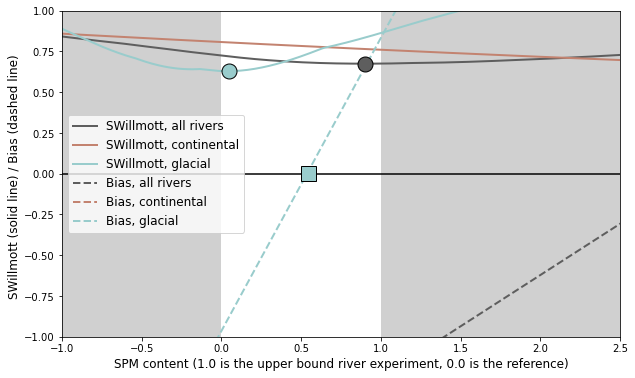

In [20]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(a_values, willmotts            , '-' , c='#5e5e5e', linewidth=2.0, markersize=5, label='SWillmott, all rivers')
ax.plot(a_values, willmotts_continental, '-' , c='#c38370', linewidth=2.0, markersize=5, label='SWillmott, continental')
ax.plot(a_values, willmotts_glacial    , '-' , c='#99cccc', linewidth=2.0, markersize=5, label='SWillmott, glacial')
ax.plot(a_values, biases               , '--', c='#5e5e5e', linewidth=2.0, markersize=5, label='Bias, all rivers')
ax.plot(a_values, bias_continental     , '--', c='#c38370', linewidth=2.0, markersize=5, label='Bias, continental')
ax.plot(a_values, bias_glacial         , '--', c='#99cccc', linewidth=2.0, markersize=5, label='Bias, glacial')
# ax.plot([0,0], [-10,10], '--k')
plt.axvspan(-1.0, 0.0, facecolor='#a3a3a3', alpha=0.5)
plt.axvspan(1.0, 3.0, facecolor='#a3a3a3', alpha=0.5)
# ax.plot([1,1], [-10,10], '--k')
ax.plot([-10,10], [0,0], '-k')
ax.plot(a_values[ind_opt], willmotts[ind_opt], '.', c='#5e5e5e', markersize=30, markeredgecolor='k')
ax.plot(a_values[bind_opt], biases[bind_opt], 's', c='#5e5e5e', markersize=15, markeredgecolor='k')
ax.plot(a_values[ind_opt_continental], willmotts_continental[ind_opt_continental], '.', c='#c38370', markersize=30, markeredgecolor='k')
ax.plot(a_values[bind_opt_continental], bias_continental[bind_opt_continental], 's', c='#c38370', markersize=15, markeredgecolor='k')
ax.plot(a_values[ind_opt_glacial], willmotts_glacial[ind_opt_glacial], '.', c='#99cccc', markersize=30, markeredgecolor='k')
ax.plot(a_values[bind_opt_glacial], bias_glacial[bind_opt_glacial], 's', c='#99cccc', markersize=15, markeredgecolor='k')

ax.set_xlabel('SPM content (1.0 is the upper bound river experiment, 0.0 is the reference)', fontsize=12)
ax.set_ylabel('SWillmott (solid line) / Bias (dashed line) ', fontsize=12)
ax.set_ylim(-1,1)
ax.set_xlim(-1,2.5)
ax.legend(fontsize=12)

(-1.0, 10.0)

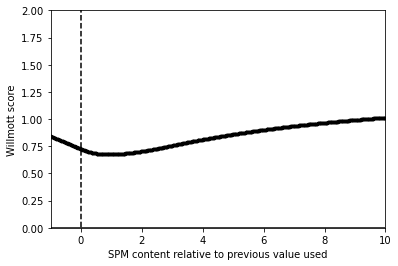

In [21]:
fig, ax = plt.subplots(1,1)

ax.plot(a_values, willmotts, '.k', markersize=5)
ax.plot([0,0], [-10,10], '--k')
ax.plot([-10,10], [0,0], '-k')

ax.set_xlabel('SPM content relative to previous value used')
ax.set_ylabel('Willmott score')
ax.set_ylim(0,2)
ax.set_xlim(-1,10)